In [198]:
from IPython.core.display import HTML
css = open('notebook_css/style-table.css').read() + open('notebook_css/style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

# Optimizing Model Parameters

## Jacobian

In [3]:
import torch

In [17]:
inp = torch.eye(5, requires_grad=True)
inp

tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]], requires_grad=True)

In [18]:
out = (inp + 1).pow(2)
out

tensor([[4., 1., 1., 1., 1.],
        [1., 4., 1., 1., 1.],
        [1., 1., 4., 1., 1.],
        [1., 1., 1., 4., 1.],
        [1., 1., 1., 1., 4.]], grad_fn=<PowBackward0>)

In [19]:
out.backward(gradient=torch.ones_like(inp), retain_graph=True)
print(f"First Call:\n{inp.grad}")

First Call:
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.],
        [2., 2., 2., 2., 4.]])


In [20]:
out.backward(gradient=torch.ones_like(inp), retain_graph=True)
print(f"Second Call:\n{inp.grad}")

Second Call:
tensor([[8., 4., 4., 4., 4.],
        [4., 8., 4., 4., 4.],
        [4., 4., 8., 4., 4.],
        [4., 4., 4., 8., 4.],
        [4., 4., 4., 4., 8.]])


In [21]:
inp.grad.zero_()
out.backward(gradient=torch.ones_like(inp), retain_graph=True)
print(f"Third Call:\n{inp.grad}")

Third Call:
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.],
        [2., 2., 2., 2., 4.]])


In [23]:
inp.grad.zero_()
out.backward(gradient=torch.ones_like(inp), retain_graph=True)
print(f"Fourth Call:\n{inp.grad}")

Fourth Call:
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.],
        [2., 2., 2., 2., 4.]])


Previously we were calling `backward()` (without function parameters).

This is essentially equivalent to calling `backward(torch.tensor(1.0))` which is a useful way to compute gradients in case of a scalar valued function; such as **loss** during NN training

## Optimizer

We initialize the optimizer by registering model parameters that need to be optimized and passing in the learning rate `lr`

Inside the training loop; optimization happend in three steps:

1. Call `optimizer.zero_grad()` to reset the gradients of the model parameters. Gradients by default adds up; to prevent counting we explicitly zero tem at each iteration

2. Backpropagate the prediction loss with `loss.backwards()`. PyTorch deposits the gradients w.r.t each parameter.

3. Once we have the graients we call `optimizer.step()` to adjust the weights of the parameters based on the graients collected in the backward pass.

In [ ]:
optimizer = torch.optim.SGD(params=model.parameter(), lr=learning_rate)

## Full Implementation

In [26]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        ## compute prediction & loss
        pred = model(X)
        loss = loss_fn(pred, y)
        
        ## Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            loss = loss.item()
            current = bacth * len(X)
            print(f"loss: {loss:>7f} | [{current:5d} / {size:5d}]")
            
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0.
    correct = 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            pred = model(X)
            loss = loss_fn(pred, y)
            test_loss += loss.item()
            correct += (pred.argmax(dim=-1) == y).type(torch.float).sum().item()
        
    test_loss /= num_batches
    correct /= size
    print(f"Test Error:\nAvg. loss: {test_loss:>8f} | Accuracy: {(100*correct):>0.1f}%")


In [27]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 10
for t in range(epochs):
    print(f"Epoch [{t+1}]:{'--'*15}\n")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn, optimizer)
print(f"DONE!!🎯🎯")

NameError: name 'model' is not defined

# Saving & Loading a model

In [28]:
from torch import nn, optim
from torchvision import models

In [30]:
resnet18 = models.resnet18(pretrained=True)
resnet18

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/imflash217/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [36]:
for params in resnet18.parameters():
    params.requires_grad = False

In [37]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [38]:
resnet18.fc

Linear(in_features=512, out_features=10, bias=True)

In [39]:
resnet18.fc = nn.Linear(in_features=512, out_features=10, bias=True)

In [40]:
resnet18.fc

Linear(in_features=512, out_features=10, bias=True)

In [41]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [56]:
for i, param in enumerate(reversed(list(resnet18.parameters()))):
    if i > 1: break
    print(f"{'---'*10}")
    print(f"{param.shape}\n{param}\n{param.requires_grad}\n")

------------------------------
torch.Size([10])
Parameter containing:
tensor([ 0.0262,  0.0441, -0.0406, -0.0184,  0.0055, -0.0107, -0.0008, -0.0121,
        -0.0333,  0.0437], requires_grad=True)
True

------------------------------
torch.Size([10, 512])
Parameter containing:
tensor([[-0.0134,  0.0272,  0.0418,  ...,  0.0233,  0.0384,  0.0063],
        [-0.0073, -0.0319,  0.0230,  ..., -0.0347, -0.0302,  0.0288],
        [ 0.0349,  0.0128,  0.0341,  ..., -0.0132, -0.0108,  0.0062],
        ...,
        [ 0.0113,  0.0283,  0.0197,  ...,  0.0263,  0.0314,  0.0398],
        [-0.0339, -0.0300,  0.0410,  ..., -0.0178,  0.0176,  0.0381],
        [-0.0310,  0.0348, -0.0219,  ...,  0.0062, -0.0208,  0.0253]],
       requires_grad=True)
True



In [57]:
x = torch.rand(size=(2,3,4,5))
x.shape

torch.Size([2, 3, 4, 5])

In [60]:
y = torch.flatten(x, 0)
y.shape                      ## [2*3*4*5]

torch.Size([120])

In [58]:
y = torch.flatten(x, 1)
y.shape                      ## [2, 3*4*5]

torch.Size([2, 60])

In [59]:
y = torch.flatten(x, 2)
y.shape                      ## [2, 3, 4*5]

torch.Size([2, 3, 20])

In [61]:
nn.Parameter?

Init signature: nn.Parameter(data=None, requires_grad=True)
Docstring:     
A kind of Tensor that is to be considered a module parameter.

Parameters are :class:`~torch.Tensor` subclasses, that have a
very special property when used with :class:`Module` s - when they're
assigned as Module attributes they are automatically added to the list of
its parameters, and will appear e.g. in :meth:`~Module.parameters` iterator.
Assigning a Tensor doesn't have such effect. This is because one might
want to cache some temporary state, like last hidden state of the RNN, in
the model. If there was no such class as :class:`Parameter`, these
temporaries would get registered too.

Arguments:
    data (Tensor): parameter tensor.
    requires_grad (bool, optional): if the parameter requires gradient. See
        :ref:`excluding-subgraphs` for more details. Default: `True`
File:           ~/anaconda3/lib/python3.7/site-packages/torch/nn/parameter.py
Type:           type
Subclasses:     


In [63]:
type(param)

torch.nn.parameter.Parameter

In [64]:
param

Parameter containing:
tensor([0.2371, 0.3433, 0.3279, 0.4642, 0.2233, 0.2370, 0.2176, 0.3793, 0.3140,
        0.2803, 0.2434, 0.2116, 0.2478, 0.2435, 0.2298, 0.3172, 0.2725, 0.6511,
        0.2925, 0.2281, 0.2279, 0.4254, 0.2342, 0.3328, 0.2632, 0.2176, 0.3180,
        0.3893, 0.1387, 0.2274, 0.3379, 0.0767, 0.2253, 0.2504, 0.1990, 0.1951,
        0.2566, 0.3253, 0.2797, 0.3149, 0.2373, 0.2533, 0.1956, 0.3236, 0.2093,
        0.2333, 0.2300, 0.5019, 0.2830, 0.1885, 0.3264, 0.2722, 0.2369, 0.2430,
        0.3625, 0.2165, 0.4700, 0.3047, 0.3675, 0.2641, 0.1979, 0.2664, 0.3448,
        0.2005, 0.2450, 0.4351, 0.2689, 0.1632, 0.3087, 0.1209, 0.2153, 0.1592,
        0.2960, 0.1423, 0.2951, 0.2706, 0.2007, 0.2939, 0.2210, 0.2243, 0.2465,
        0.3910, 0.4599, 0.5417, 0.2147, 0.3469, 0.2703, 0.2229, 0.3645, 0.2647,
        0.2421, 0.2492, 0.1666, 0.2763, 0.2560, 0.2151, 0.3363, 0.2767, 0.2516,
        0.2988, 0.2622, 0.3499, 0.3001, 0.3907, 0.3184, 0.2233, 0.2649, 0.2110,
        0.2034, 0.

In [65]:
torch.autograd.Function?

Init signature: torch.autograd.Function(self, /, *args, **kwargs)
Docstring:     
Records operation history and defines formulas for differentiating ops.

See the Note on extending the autograd engine for more details on how to use
this class: https://pytorch.org/docs/stable/notes/extending.html#extending-torch-autograd

Every operation performed on :class:`Tensor` s creates a new function
object, that performs the computation, and records that it happened.
The history is retained in the form of a DAG of functions, with edges
denoting data dependencies (``input <- output``). Then, when backward is
called, the graph is processed in the topological ordering, by calling
:func:`backward` methods of each :class:`Function` object, and passing
returned gradients on to next :class:`Function` s.

Normally, the only way users interact with functions is by creating
subclasses and defining new operations. This is a recommended way of
extending torch.autograd.

Examples::

    >>> class Exp(Functio

In [71]:
param.data.sub_

# Training a Classifier

In [72]:
import torch
import torchvision

In [73]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

batch_size = 4

train_dataset = torchvision.datasets.CIFAR10(root="data/",
                                             train=True,
                                             download=True, 
                                             transform=transform,
                                            )
test_dataset = torchvision.datasets.CIFAR10(root="data/", 
                                            train=False, 
                                            download=True, 
                                            transform=transform,
                                           )

train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size, 
                                               shuffle=True,
                                               num_workers=2,
                                              )

test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=batch_size,
                                              shuffle=False,
                                              num_workers=2,
                                             )

classes = ("plane", "car", "bird", "cat", "deer", 
           "dog", "frog", "horse", "ship", "truck",)


0it [00:00, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


In [74]:
len(train_dataset), len(test_dataset)

(50000, 10000)

torch.Size([3, 36, 138]) (3, 36, 138) (36, 138, 3)


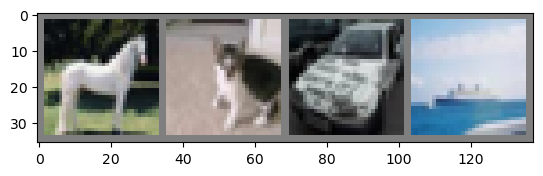

horse cat car ship


In [90]:
import matplotlib.pyplot as plt
import numpy as np


def show_image(img):
    """Plots the image"""
    img = img/2 + 0.5
    img_np = img.numpy()
    img_t = np.transpose(img_np, axes=(-2, -1, -3))
    print(img.shape, img_np.shape, img_t.shape)
    plt.imshow(img_t)
    plt.show()
    
## get some random image
images, labels = next(iter(train_dataloader))

## show images
show_image(torchvision.utils.make_grid(images))

## print labels
print(" ".join(classes[i] for i in labels))

## Define a Convolutional Neural Network

In [105]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=(5,5))
        self.pool = nn.MaxPool2d(kernel_size=(2,2))
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5,5))
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

In [109]:
net = Net()
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## Define a loss function & an optimizer

In [110]:
import torch.optim

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=net.parameters(), lr=1e-3, momentum=0.9)


## Train the network

In [111]:
num_epochs = 20

for epoch in range(num_epochs):
    running_loss = 0
    print(f"💈Epoch[{epoch+1:2d}/{num_epochs:2d}]")
    for batch, (X, y) in enumerate(train_dataloader):
        ## calculate the loss
        pred = net(X)
        loss = loss_fn(pred, y)
        
        ## backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        ## log the statistics
        running_loss += loss.item()
        if batch % 2000 == 1999:
            print(f"\t minibatch[{(batch+1):>5d}] | running_loss: {(running_loss/2000):.5f}")
            running_loss = 0.0
        

💈Epoch[ 1/20]
	 minibatch[ 2000] | running_loss: 2.28487
	 minibatch[ 4000] | running_loss: 1.96404
	 minibatch[ 6000] | running_loss: 1.75157
	 minibatch[ 8000] | running_loss: 1.63266
	 minibatch[10000] | running_loss: 1.55427
	 minibatch[12000] | running_loss: 1.49077
💈Epoch[ 2/20]
	 minibatch[ 2000] | running_loss: 1.40760
	 minibatch[ 4000] | running_loss: 1.37755
	 minibatch[ 6000] | running_loss: 1.36043
	 minibatch[ 8000] | running_loss: 1.33459
	 minibatch[10000] | running_loss: 1.30502
	 minibatch[12000] | running_loss: 1.28475
💈Epoch[ 3/20]
	 minibatch[ 2000] | running_loss: 1.21293
	 minibatch[ 4000] | running_loss: 1.22123
	 minibatch[ 6000] | running_loss: 1.18209
	 minibatch[ 8000] | running_loss: 1.20947
	 minibatch[10000] | running_loss: 1.17915
	 minibatch[12000] | running_loss: 1.18546
💈Epoch[ 4/20]
	 minibatch[ 2000] | running_loss: 1.08842
	 minibatch[ 4000] | running_loss: 1.11599
	 minibatch[ 6000] | running_loss: 1.10871
	 minibatch[ 8000] | running_loss: 1.1063

KeyboardInterrupt: 

# Inside of PyTorch (by @jphoward)

In [1]:
from pathlib import Path
import requests

In [2]:
DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

In [3]:
PATH

PosixPath('data/mnist')

In [4]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

In [5]:
x_train.shape, y_train.shape

((50000, 784), (50000,))

In [6]:
x_valid.shape, y_valid.shape

((10000, 784), (10000,))

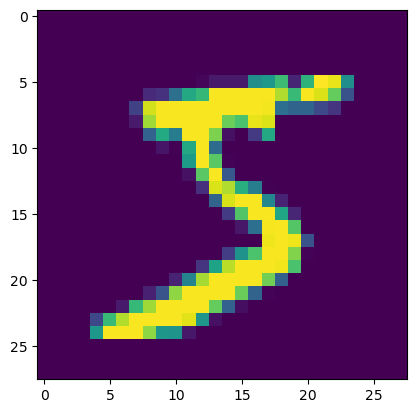

(50000, 784)


In [7]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(x_train[0].reshape(28, 28))
plt.show()
print(x_train.shape)

In [18]:
import torch

x_train, y_train, x_valid, y_valid = map(torch.tensor, 
                                          (x_train, y_train, x_valid, y_valid)
                                         )

n, c = x_train.shape
print(x_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
torch.Size([50000, 784])
tensor(0) tensor(9)


/Users/imflash217/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [19]:
## 🎯🎯🎯🎯
##
import math

weights = torch.randn(size=(784,10)) / math.sqrt(784)
weights.requires_grad_(True)
bias = torch.zeros(size=(10,), requires_grad=True)

In [20]:
weights.requires_grad

True

In [21]:
bias.requires_grad

True

In [24]:
## 🎯🎯🎯🎯
##

def log_softmax(x):
    residue = x.exp().sum(-1).log().unsqueeze(-1)
    return x - residue

def model(x_batch):
    out_batch = x_batch @ weights + bias
    return log_softmax(out_batch)


In [28]:
## 🎯🎯🎯🎯
##

batch_size = 64

x_batch = x_train[:batch_size]
pred_batch = model(x_batch)

print(pred_batch[0], "\n")
print(pred_batch.shape)

tensor([-2.1465, -1.8755, -2.4180, -2.1391, -1.9722, -2.6350, -2.7429, -2.2622,
        -2.5418, -2.7354], grad_fn=<SelectBackward>) 

torch.Size([64, 10])


In [29]:
## 🎯🎯🎯🎯
##

def nll(input_, target_):
    return -input_[range(target_.shape[0]), target_].mean()

loss_fn = nll

In [30]:
## 🎯🎯🎯🎯
##
y_batch = y_train[:batch_size]
loss = loss_fn(pred_batch, y_batch)
print(loss)

tensor(2.3431, grad_fn=<NegBackward>)


In [33]:
## 🎯🎯🎯🎯
##

def accuracy(output_, y_batch):
    preds = torch.argmax(output_, dim=-1)
    return (preds == y_batch).float().mean()

In [34]:
acc = accuracy(pred_batch, y_batch)
print(acc)

tensor(0.0625)


In [52]:
## 🎯🎯🎯🎯
##

from IPython.core.debugger import set_trace

lr = 0.5
num_epochs = 2
num_batches = (n-1) // batch_size + 1
for epoch in range(num_epochs):
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    for i in range(num_batches):
        ## set_trace()
        start_i = i * batch_size
        end_i = start_i + batch_size
        x_batch = x_train[start_i:end_i]      ## grab a minibatch of data
        y_batch = y_train[start_i:end_i]
        
        pred_batch = model(x_batch)
        loss = loss_fn(pred_batch, y_batch)
        
        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()
        if i % 200 == 199:
            print(f"\t batch [{i:4d} /{num_batches:4d}]|  loss: {loss.item():.5f}")


Epoch [1/2]
	 batch [ 199 / 782]|  loss: 0.26843
	 batch [ 399 / 782]|  loss: 0.34530
	 batch [ 599 / 782]|  loss: 0.28558

Epoch [2/2]
	 batch [ 199 / 782]|  loss: 0.26778
	 batch [ 399 / 782]|  loss: 0.34566
	 batch [ 599 / 782]|  loss: 0.28462


In [53]:
loss_fn(model(x_batch), y_batch), accuracy(model(x_batch), y_batch)

(tensor(0.0502, grad_fn=<NegBackward>), tensor(1.))

In [55]:
## 🎯🎯🎯🎯
##

import torch.nn.functional as F

loss_fn = F.cross_entropy

def model(x_batch):
    return x_batch @ weights + bias


In [56]:
loss_fn(model(x_batch), y_batch), accuracy(model(x_batch), y_batch)

(tensor(0.0502, grad_fn=<NllLossBackward>), tensor(1.))

In [57]:
## 🎯🎯🎯🎯
##

from torch import nn

class MNIST_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(size=(784, 10)) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(size=(10,)))
        
    def forward(self, xb):
        return xb @ self.weights + self.bias

In [58]:
model = MNIST_Logistic()

In [59]:
model

MNIST_Logistic()

In [60]:
print(loss_fn(model(x_batch), y_batch))

tensor(2.4465, grad_fn=<NllLossBackward>)


In [61]:
## 🎯🎯🎯🎯
##

with torch.no_grad():
    for p in model.parameters():
        p -= p.grad * lr
    model.zero_grad()

TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

In [64]:
p.requires_grad

True

In [69]:
## 🎯🎯🎯🎯
##

def fit():
    for epoch in range(num_epochs):
        print(f"\n Epoch [{epoch+1}/{num_epochs}]")
        for i in range(num_batches):
            start_i = i * batch_size
            end_i = start_i + batch_size
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_fn(pred, yb)
            
            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()
            if i % 200 == 0:
                print(f"\t minibatch [{i:4d} / {num_batches:4d}] | loss: {loss.item()}")
            

In [70]:
fit()


 Epoch [1/2]
	 minibatch [   0 /  782] | loss: 0.19421565532684326
	 minibatch [ 200 /  782] | loss: 0.17413318157196045
	 minibatch [ 400 /  782] | loss: 0.19378973543643951
	 minibatch [ 600 /  782] | loss: 0.20261113345623016

 Epoch [2/2]
	 minibatch [   0 /  782] | loss: 0.18589738011360168
	 minibatch [ 200 /  782] | loss: 0.17140400409698486
	 minibatch [ 400 /  782] | loss: 0.19101333618164062
	 minibatch [ 600 /  782] | loss: 0.1987023800611496


In [72]:
print(loss_fn(model(x_batch), y_batch))

tensor(0.0604, grad_fn=<NllLossBackward>)


In [82]:
## 🎯🎯🎯🎯
##

class MNIST_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(in_features=784, out_features=10)
        
    def forward(self, xb):
        return self.lin(xb)
    

In [83]:
model = MNIST_Logistic()
print(loss_fn(model(x_batch), y_batch))

tensor(2.2893, grad_fn=<NllLossBackward>)


In [84]:
model = MNIST_Logistic()
fit()
print(loss_fn(model(x_batch), y_batch))



 Epoch [1/2]
	 minibatch [   0 /  782] | loss: 2.303011894226074
	 minibatch [ 200 /  782] | loss: 0.30543839931488037
	 minibatch [ 400 /  782] | loss: 0.23813964426517487
	 minibatch [ 600 /  782] | loss: 0.26431015133857727

 Epoch [2/2]
	 minibatch [   0 /  782] | loss: 0.28001660108566284
	 minibatch [ 200 /  782] | loss: 0.1976470947265625
	 minibatch [ 400 /  782] | loss: 0.21188215911388397
	 minibatch [ 600 /  782] | loss: 0.22766846418380737
tensor(0.0804, grad_fn=<NllLossBackward>)


In [94]:
## 🎯🎯🎯🎯
##

from torch import optim

def get_model():
    model = MNIST_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_fn(model(x_batch), y_batch))

for epoch in range(num_epochs):
    print(f"{'--'*25}\nEpoch[{epoch+1}/{num_epochs}]")
    for i in range(num_batches):
        start_i = i * batch_size
        end_i = start_i + batch_size
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        
        pred = model(xb)
        loss = loss_fn(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        if i%200 == 0:
            print(f"\t minibatch[{i:4d} / {num_batches:4d}] | loss: {loss.item():.5f}")
print(f"{'--'*25}")
print(loss_fn(model(x_batch), y_batch))

tensor(2.2972, grad_fn=<NllLossBackward>)
--------------------------------------------------
Epoch[1/2]
	 minibatch[   0 /  782] | loss: 2.35864
	 minibatch[ 200 /  782] | loss: 0.29606
	 minibatch[ 400 /  782] | loss: 0.23349
	 minibatch[ 600 /  782] | loss: 0.26183
--------------------------------------------------
Epoch[2/2]
	 minibatch[   0 /  782] | loss: 0.27752
	 minibatch[ 200 /  782] | loss: 0.19458
	 minibatch[ 400 /  782] | loss: 0.20846
	 minibatch[ 600 /  782] | loss: 0.22680
--------------------------------------------------
tensor(0.0831, grad_fn=<NllLossBackward>)


In [95]:
from torch.utils.data import TensorDataset

In [102]:
len(x_train)

50000

In [103]:
x_train.shape

torch.Size([50000, 784])

In [106]:
train_ds = TensorDataset(x_train, y_train)
len(train_ds)

50000

In [108]:
xb, yb = train_ds[0:5]
xb.shape, yb.shape

(torch.Size([5, 784]), torch.Size([5]))

In [109]:
yb

tensor([5, 0, 4, 1, 9])

In [168]:

def loss_batch(model, loss_fn, xb, yb, opt=None):
    pred = model(xb)
    loss = loss_fn(pred, yb)
    if opt:
        loss.backward()
        opt.step()
        opt.zero_grad()
    return loss.item(), len(xb)
    
def fit(num_epochs, model, opt, loss_fn, train_dl, valid_dl):
    for epoch in range(num_epochs):
        
        model.train()
        losses, nums = zip(*[loss_batch(model, loss_fn, xb, yb, opt) for xb, yb in train_dl])
        train_loss = np.multiply(losses, nums).sum() / sum(nums)
            
        model.eval()
        with torch.no_grad():
            val_losses, val_nums = zip(*[loss_batch(model, loss_fn, xb, yb) for xb, yb in valid_dl])
        val_loss = np.multiply(val_losses, val_nums).sum() / sum(val_nums)
        
        print(f"Epoch [{(epoch+1):2d}/{num_epochs:2d}] | train_loss: {train_loss:4f} | valid_loss: {val_loss:4f}")
        

In [162]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
        
    def forward(self, x):
        return self.func(x)

def preprocess(x):
    return x.view(-1, 1, 28, 28)


In [163]:
train_ds = torch.utils.data.TensorDataset(x_train, y_train)
valid_ds = torch.utils.data.TensorDataset(x_valid, y_valid)
train_dl = torch.utils.data.DataLoader(dataset=train_ds, batch_size=64)
valid_dl = torch.utils.data.DataLoader(dataset=valid_ds, batch_size=64*2)

In [164]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=4),
    Lambda(lambda x: x.view(x.shape[0], -1)),
)

opt = optim.SGD(model.parameters(), lr=lr)
fit(num_epochs=20, model=model, opt=opt, loss_fn=loss_fn, train_dl=train_dl, valid_dl=valid_dl)

Epoch [ 1/20] | train_loss: 1.145351 | valid_loss: 1.363253
Epoch [ 2/20] | train_loss: 0.370123 | valid_loss: 0.358585
Epoch [ 3/20] | train_loss: 0.276475 | valid_loss: 0.339897
Epoch [ 4/20] | train_loss: 0.235609 | valid_loss: 0.271940
Epoch [ 5/20] | train_loss: 0.211959 | valid_loss: 0.240838
Epoch [ 6/20] | train_loss: 0.195047 | valid_loss: 0.210017
Epoch [ 7/20] | train_loss: 0.180932 | valid_loss: 0.186624
Epoch [ 8/20] | train_loss: 0.169549 | valid_loss: 0.193381
Epoch [ 9/20] | train_loss: 0.160406 | valid_loss: 0.217786
Epoch [10/20] | train_loss: 0.152626 | valid_loss: 0.240295
Epoch [11/20] | train_loss: 0.146434 | valid_loss: 0.237679
Epoch [12/20] | train_loss: 0.140819 | valid_loss: 0.218612
Epoch [13/20] | train_loss: 0.135939 | valid_loss: 0.219150
Epoch [14/20] | train_loss: 0.131477 | valid_loss: 0.195003
Epoch [15/20] | train_loss: 0.127360 | valid_loss: 0.186916
Epoch [16/20] | train_loss: 0.123758 | valid_loss: 0.170595
Epoch [17/20] | train_loss: 0.120180 | v

In [165]:
loss_fn

<function torch.nn.functional.cross_entropy(input, target, weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')>

In [166]:
opt

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.5
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [167]:
model

Sequential(
  (0): Lambda()
  (1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (2): ReLU()
  (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): ReLU()
  (5): Conv2d(16, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (6): ReLU()
  (7): AvgPool2d(kernel_size=4, stride=4, padding=0)
  (8): Lambda()
)

## Wrapped DataLoader

In [190]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
        
    def forward(self, x):
        return self.func(x)

    
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y


class WrappedDataLoader:
    def __init__(self, dl, func):
        super().__init__()
        self.dl = dl
        self.func = func
        
    def __len__(self):
        return len(dl)
    
    def __iter__(self):
        for batch in self.dl:
            yield self.func(*batch)
            

In [193]:
def get_dls(train_ds, valid_ds, bs):
    train_dl = torch.utils.data.DataLoader(dataset=train_ds, batch_size=bs)
    valid_dl = torch.utils.data.DataLoader(dataset=valid_ds, batch_size=2*bs)
    return train_dl, valid_dl
    

In [195]:
batch_size

64

In [197]:
train_ds = torch.utils.data.TensorDataset(x_train, y_train)
valid_ds = torch.utils.data.TensorDataset(x_valid, y_valid)
train_dl, valid_dl = get_dls(train_ds, valid_ds, batch_size)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [192]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.shape[0], -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(num_epochs=20, model=model, opt=opt, loss_fn=loss_fn, train_dl=train_dl, valid_dl=valid_dl)

Epoch [ 1/20] | train_loss: 0.919512 | valid_loss: 0.569991
Epoch [ 2/20] | train_loss: 0.471716 | valid_loss: 0.401526
Epoch [ 3/20] | train_loss: 0.401352 | valid_loss: 0.309470
Epoch [ 4/20] | train_loss: 0.411155 | valid_loss: 0.288481
Epoch [ 5/20] | train_loss: 0.362021 | valid_loss: 0.296754
Epoch [ 6/20] | train_loss: 0.407908 | valid_loss: 0.456740
Epoch [ 7/20] | train_loss: 0.372598 | valid_loss: 0.307797
Epoch [ 8/20] | train_loss: 0.354015 | valid_loss: 0.294139
Epoch [ 9/20] | train_loss: 0.359534 | valid_loss: 0.325992
Epoch [10/20] | train_loss: 0.335343 | valid_loss: 0.384450
Epoch [11/20] | train_loss: 0.317497 | valid_loss: 0.273711
Epoch [12/20] | train_loss: 0.344566 | valid_loss: 0.384467
Epoch [13/20] | train_loss: 0.335513 | valid_loss: 0.354955
Epoch [14/20] | train_loss: 0.333675 | valid_loss: 0.262305
Epoch [15/20] | train_loss: 0.302853 | valid_loss: 0.278761
Epoch [16/20] | train_loss: 0.313799 | valid_loss: 0.275258
Epoch [17/20] | train_loss: 0.295675 | v